# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

> **Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results, and verify any scientific conclusions independently.

## Overview

This notebook explores Dandiset 001174, which contains calcium imaging data recorded from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques. The data was collected using in vivo one-photon calcium imaging with genetically encoded calcium indicators (GCaMP6f) through miniature microscopes and GRIN lenses. Recordings were made while macaques were at rest and performing arm-reaching tasks.

[View on DANDI Archive](https://dandiarchive.org/dandiset/001174/0.250331.2218)

### Dataset Citation

Galvan, Adriana; Martel, Anne-Caroline; Pittard, Damien; Devergnas, Annaelle; Risk, Benjamin; Nassi, Jonathan J.; Yu, Waylin; Downer, Joshua D.; Wichmann, Thomas (2025) Calcium imaging in SMA and M1 of macaques (Version 0.250331.2218) [Data set]. DANDI Archive. https://doi.org/10.48324/dandi.001174/0.250331.2218

## Notebook Contents

This notebook will guide you through:

1. Exploring the Dandiset's structure and metadata
2. Examining NWB file organization and contents  
3. Accessing and visualizing raw calcium imaging frames
4. Working with ROI/cell masks and their spatial distribution
5. Analyzing fluorescence traces and event detection data
6. Computing basic activity statistics for cells
7. Demonstrating linking and matching of traces to ROI masks

By the end of this notebook, you should understand how to access and work with the key data modalities in this calcium imaging dataset.

## Required Packages

In [1]:
# Import required packages
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient
from itertools import islice

## Exploring Dandiset Metadata

First, let's use the DANDI Python API to get general information about the dandiset.

In [2]:
# Access dandiset metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset description: {metadata.get('description', 'No description available')[:500]}...")
print(f"License: {metadata.get('license', 'Unknown')}")

Dandiset name: Calcium imaging in SMA and M1 of macaques
Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218
Dandiset description: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We used this method to examine activity patterns of projection neurons in deep layers of the supplementary motor (SMA) and primary motor areas (M1) in four rhesus macaques. We implanted gradient index le...
License: ['spdx:CC-BY-4.0']


## Exploring Files in the Dandiset

Let's get a list of NWB files in this dandiset to understand its organization.

In [3]:
# List NWB files (showing up to 20)
assets = list(islice(dandiset.get_assets_by_glob("*.nwb"), 20))

print(f"Number of .nwb files (showing up to 20): {len(assets)}\n")
for i, asset in enumerate(assets):
    print(f"{i+1}. {asset.path} - {asset.size/1e9:.2f} GB")

Number of .nwb files (showing up to 20): 20

1. sub-V/sub-V_ses-20230309T110929_ophys.nwb - 10.66 GB
2. sub-Q/sub-Q_ophys.nwb - 0.79 GB
3. sub-Q/sub-Q_ses-20220922T131747_ophys.nwb - 0.79 GB
4. sub-Q/sub-Q_ses-20221003T131952_ophys.nwb - 1.70 GB
5. sub-Q/sub-Q_ses-20221028T121142_ophys.nwb - 1.56 GB
6. sub-Q/sub-Q_ses-20221201T132256_ophys.nwb - 1.66 GB
7. sub-Q/sub-Q_ses-20221202T122907_ophys.nwb - 1.57 GB
8. sub-Q/sub-Q_ses-20221206T121002_ophys.nwb - 25.12 GB
9. sub-Q/sub-Q_ses-20220915T133954_ophys.nwb - 1.18 GB
10. sub-Q/sub-Q_ses-20221201T134628_ophys.nwb - 0.84 GB
11. sub-Q/sub-Q_ses-20221028T123313_ophys.nwb - 1.12 GB
12. sub-Q/sub-Q_ses-20220922T133032_ophys.nwb - 1.57 GB
13. sub-Q/sub-Q_ses-20221003T134805_ophys.nwb - 1.56 GB
14. sub-Q/sub-Q_ses-20221202T125146_ophys.nwb - 0.91 GB
15. sub-Q/sub-Q_ses-20221206T123719_ophys.nwb - 0.90 GB
16. sub-V/sub-V_ses-20230316T094035_ophys.nwb - 10.25 GB
17. sub-V/sub-V_ses-20230309T104556_ophys.nwb - 24.74 GB
18. sub-F/sub-F_ses-20240213

## NWB File Organization

We can see that the data is organized by subject (e.g., sub-Q, sub-V, sub-F, sub-U), with multiple sessions per subject. Each file follows the naming convention:

`sub-<SubjectID>/sub-<SubjectID>_ses-<DateTime>_ophys.nwb`

File sizes vary from around 0.8 GB to 25 GB, depending on the session's length and data recorded.

Let's examine the structure of one of these files in detail.

## Examining the Structure of an NWB File

We'll load an example NWB file and explore its structure and contents, focusing on the calcium imaging data and related processing.

In [4]:
# Select a representative NWB file
asset_path = 'sub-Q/sub-Q_ses-20221206T121002_ophys.nwb'
asset = next(dandiset.get_assets_by_glob(asset_path))
url = asset.download_url

# Open the file remotely without downloading
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Print basic session and subject metadata
print('File:', asset_path)
print('Session description:', nwb.session_description)
print('Session start time:', nwb.session_start_time)
print('\nSubject information:')
print('  Subject ID:', nwb.subject.subject_id)
print('  Species:', nwb.subject.species)
print('  Sex:', nwb.subject.sex)
print('  Age:', getattr(nwb.subject, 'age', 'n/a'))

# Check key data objects and their dimensions
ophys = nwb.processing['ophys']
fluorescence = ophys.data_interfaces['Fluorescence']
rrs = fluorescence.roi_response_series['RoiResponseSeries']
fluor_shape = rrs.data.shape

plane_seg = ophys.data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
roi_df = plane_seg.to_dataframe()

onphs = nwb.acquisition['OnePhotonSeries']
movie_shape = onphs.data.shape

print('\nData dimensions:')
print('  Raw movie (frames, height, width):', movie_shape)
print('  Fluorescence traces (time points, cells):', fluor_shape)
print('  Number of segmented cells (ROIs):', len(roi_df))
print('  Sampling rate:', rrs.rate, 'Hz')

File: sub-Q/sub-Q_ses-20221206T121002_ophys.nwb
Session description: Calcium imaging in SMA during the spontaneous condition
Session start time: 2022-12-06 12:10:02.429000+00:00

Subject information:
  Subject ID: Q
  Species: Macaca mulatta
  Sex: F
  Age: P5Y



Data dimensions:
  Raw movie (frames, height, width): (12218, 1280, 800)
  Fluorescence traces (time points, cells): (12218, 18)
  Number of segmented cells (ROIs): 18
  Sampling rate: 10.0 Hz


## NWB File Structure Summary

The NWB file contains several key data components:

1. **Raw Movie**: One-photon calcium imaging frames (`nwb.acquisition['OnePhotonSeries'].data`)
2. **Fluorescence Traces**: Extracted cell activity traces (`nwb.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries'].data`)
3. **Event Amplitudes**: Detected calcium events (`nwb.processing['ophys'].data_interfaces['EventAmplitude'].data`)
4. **Cell Masks**: Spatial footprints of segmented cells (`nwb.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']['image_mask']`)

Let's visualize some of these components to get a better understanding of the data.

## Visualizing Raw Calcium Imaging Frames

First, let's look at some raw calcium imaging frames to understand what the data looks like before processing.

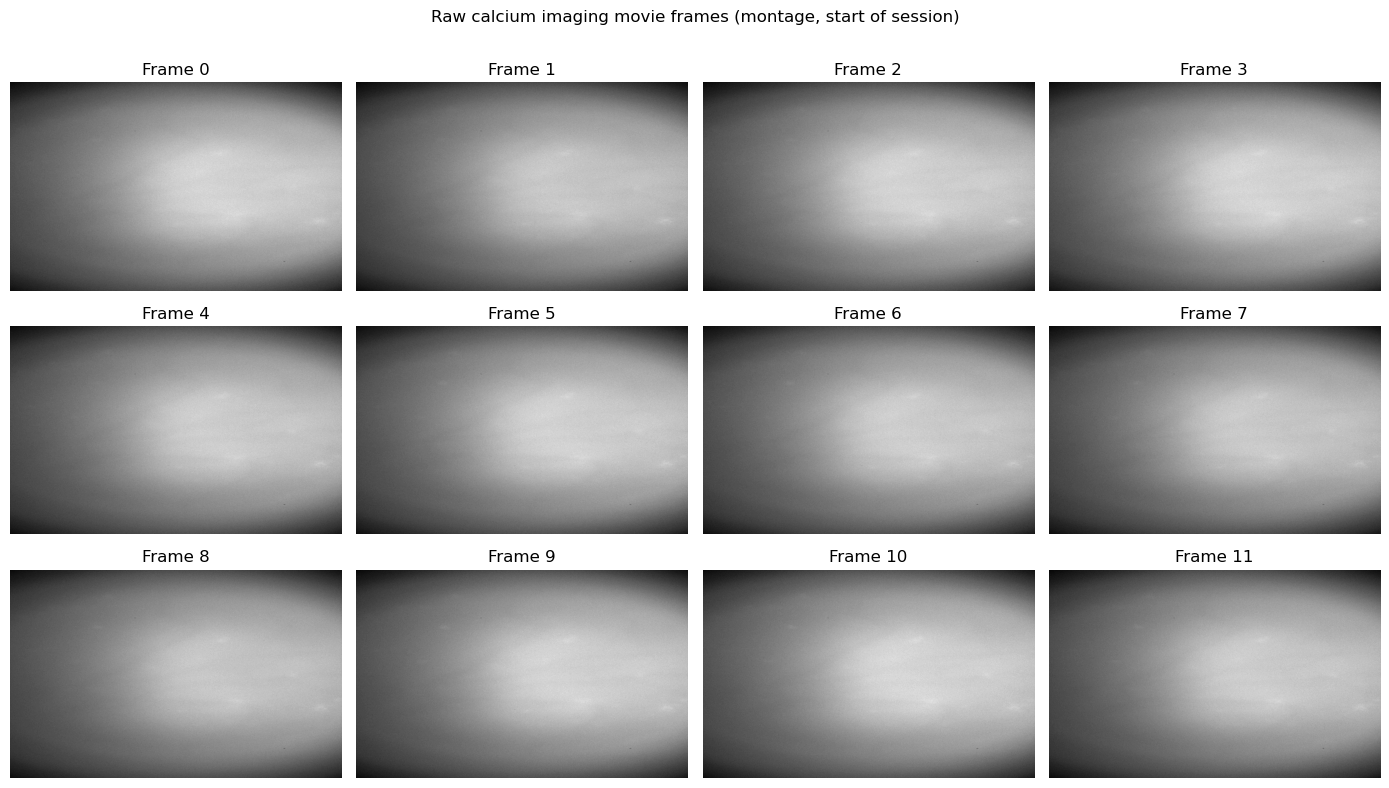

In [5]:
# Preview a short segment of the raw movie frames
frames_to_show = 12  # ~1.2 seconds at 10 Hz
movie_segment = onphs.data[:frames_to_show]

# Make montage (frames in a grid)
n_cols = 4
n_rows = int(np.ceil(frames_to_show / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,8))

for i in range(frames_to_show):
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(movie_segment[i], cmap='gray', aspect='auto')
    ax.set_title(f'Frame {i}')
    ax.axis('off')

# Turn off any unused subplots
for i in range(frames_to_show, n_rows*n_cols):
    axes.flat[i].axis('off')

plt.suptitle('Raw calcium imaging movie frames (montage, start of session)')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The raw frames show the field of view through the miniscope. Cells aren't readily visible in the raw frames without further processing. The image shows a typical calcium imaging field of view with varying brightness levels. The actual cell activity becomes apparent only after segmentation and trace extraction.

## Visualizing Segmented Cell Masks (ROIs)

Next, let's look at the segmented cell masks (ROIs) to see where the cells were detected in the field of view.

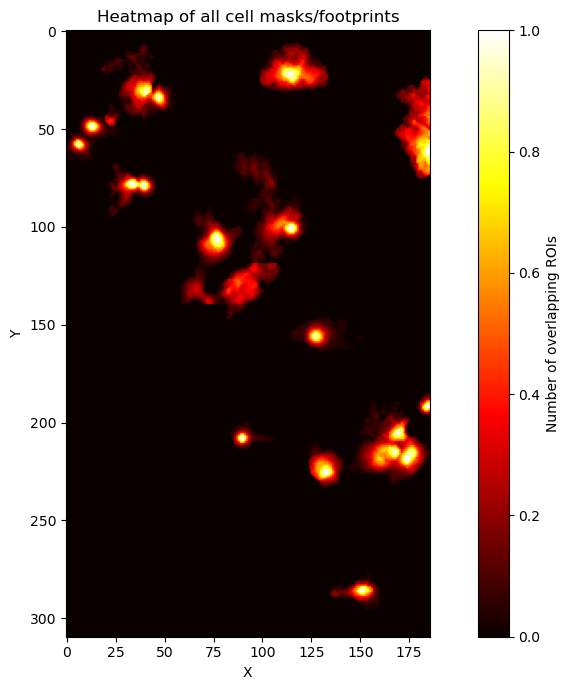

Cell ROI sizes (number of nonzero pixels):
[240, 201, 190, 641, 143, 262, 653, 176, 203, 637, 417, 411, 69, 475, 267, 304, 467, 2304]
Mean ± std of ROI size: 447.77777777777777 ± 482.62909102764706


In [6]:
# Get all cell masks and create a heatmap showing their distribution
mask_arrays = [plane_seg['image_mask'].data[i][:] for i in range(len(roi_df))]
mask_stack = np.stack(mask_arrays, axis=0)

# Create a maximum projection to show all ROIs
max_mask = np.max(mask_stack, axis=0)

plt.figure(figsize=(10,7))
plt.imshow(max_mask, cmap='hot')
plt.title('Heatmap of all cell masks/footprints')
plt.colorbar(label='Number of overlapping ROIs')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Calculate some statistics about ROI sizes
roi_sizes = [np.count_nonzero(mask) for mask in mask_arrays]
print('Cell ROI sizes (number of nonzero pixels):')
print(roi_sizes)
print('Mean ± std of ROI size:', np.mean(roi_sizes), '±', np.std(roi_sizes))

The heatmap shows the spatial distribution of all 18 segmented cells in the field of view. Each bright spot represents a cell or group of cells. This visualization helps us understand where the cells are located and how they're distributed.

The ROI sizes vary considerably, with a mean size of about 448 pixels but a large standard deviation of 483, indicating high variability in cell footprint sizes.

## Examining Individual Cell Masks

Let's look at the spatial mask for a single cell to better understand what these ROI footprints look like.

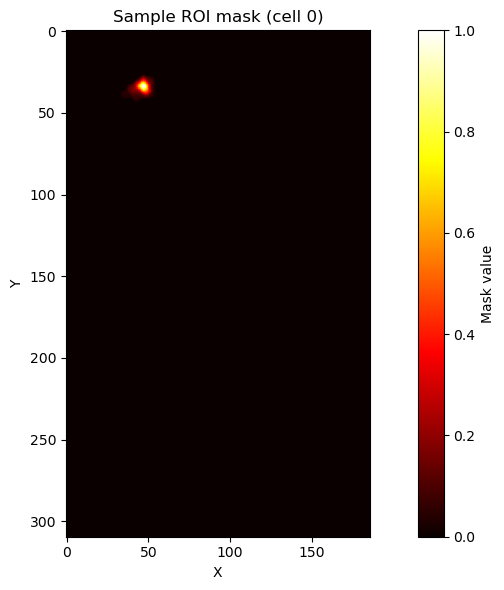

In [7]:
# Visualize the first cell's mask
cell_idx = 0  # First cell
cell_mask = mask_arrays[cell_idx]

plt.figure(figsize=(10,6))
plt.imshow(cell_mask, cmap='hot')
plt.title(f'Sample ROI mask (cell {cell_idx})')
plt.colorbar(label='Mask value')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

Each ROI mask shows the spatial footprint of a single cell. The values in the mask generally represent the weights used when extracting the fluorescence trace from the raw movie. Higher values (brighter colors) indicate regions more strongly associated with the cell.

## Analyzing Fluorescence Traces

Now let's look at the extracted fluorescence trace for a cell. This time series shows the calcium-dependent fluorescence over time.

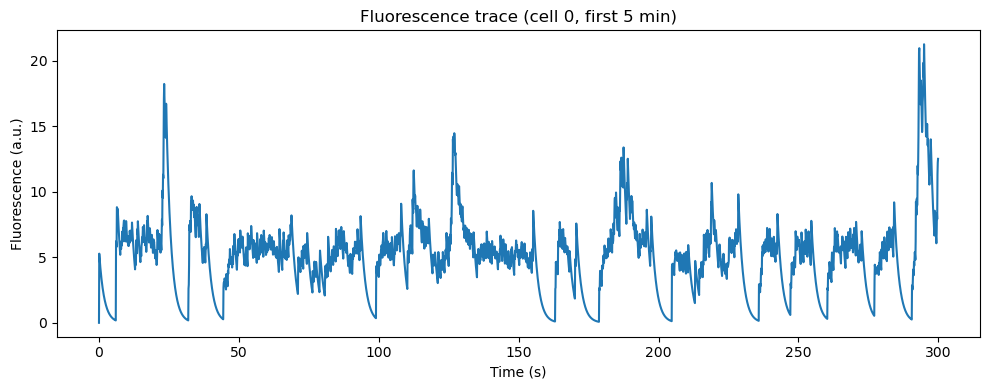

In [8]:
# Plot fluorescence trace for the first cell
sampling_rate = rrs.rate
n_seconds_plot = 5*60  # 5 minutes
n_samples_plot = int(n_seconds_plot * sampling_rate)

# Get the trace for the first cell
f_trace = rrs.data[:n_samples_plot, 0]  # Cell 0, first 5 minutes

plt.figure(figsize=(10,4))
plt.plot(np.arange(n_samples_plot)/sampling_rate, f_trace)
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Fluorescence trace (cell 0, first 5 min)')
plt.tight_layout()
plt.show()

The fluorescence trace shows the calcium activity of the cell over time. The peaks in the trace likely correspond to neural activity. GCaMP fluorescence typically rises quickly when a neuron fires and then decays more slowly as calcium is pumped out of the cell.

## Analyzing Event Amplitudes

In addition to raw fluorescence traces, the dataset includes detected calcium events. Let's examine the event amplitude trace for the same cell.

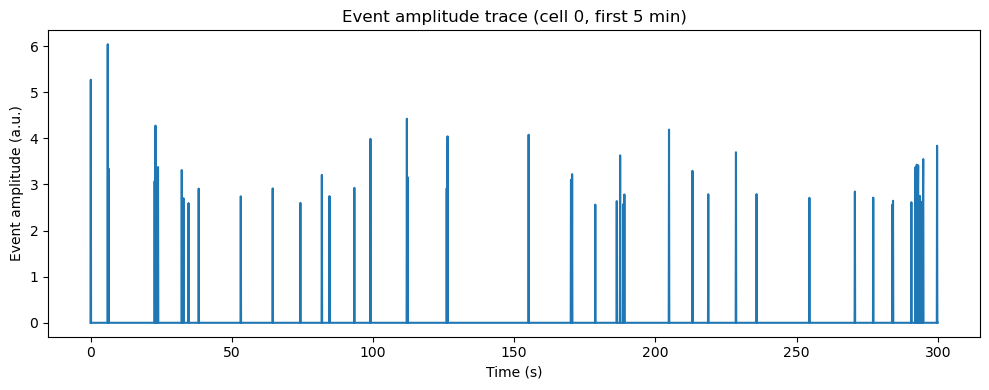

In [9]:
# Plot event amplitude trace for the first cell
event_amp = ophys.data_interfaces['EventAmplitude']
ampl_trace = event_amp.data[:n_samples_plot, 0]  # Cell 0, first 5 minutes

plt.figure(figsize=(10,4))
plt.plot(np.arange(n_samples_plot)/sampling_rate, ampl_trace)
plt.xlabel('Time (s)')
plt.ylabel('Event amplitude (a.u.)')
plt.title('Event amplitude trace (cell 0, first 5 min)')
plt.tight_layout()
plt.show()

The event amplitude trace shows detected calcium events. Unlike the raw fluorescence trace, which contains baseline fluorescence and gradual changes, the event trace is much sparser and shows only detected "events" - likely corresponding to bursts of neural activity.

## Calculating Event Rates for All Cells

To get a better understanding of the neural activity across all cells, we can calculate summary statistics like event rates (events per minute).

Event rates (per min) for each cell:
[10.07, 1.03, 6.97, 1.57, 23.08, 1.82, 1.23, 1.62, 3.58, 2.26, 4.08, 6.24, 0.64, 5.3, 1.03, 49.4, 39.14, 70.96]
Mean ± std event rate: 12.78 ± 19.53


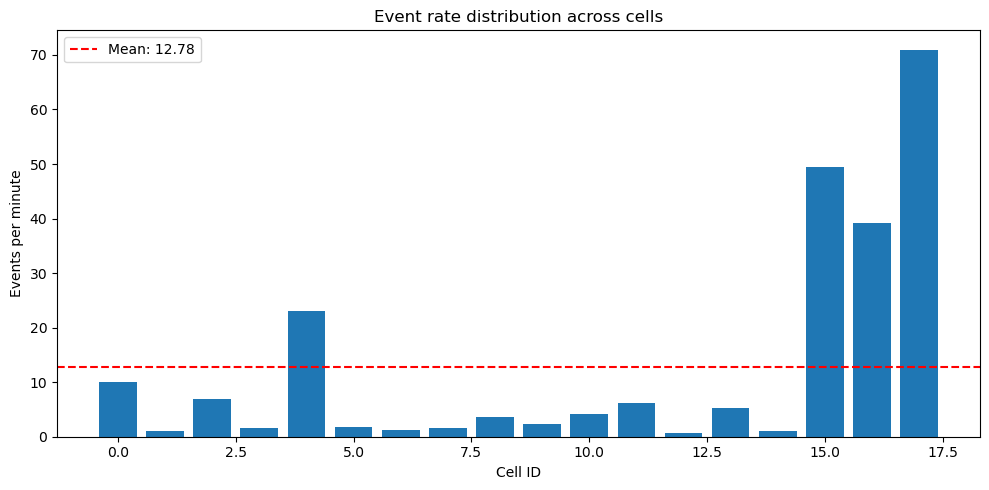

In [10]:
# Calculate event rates for all cells
num_cells = rrs.data.shape[1]
minutes = rrs.data.shape[0] / sampling_rate / 60
cell_event_counts = [(event_amp.data[:,i] > 0).sum() for i in range(num_cells)]
cell_event_rates = [count / minutes for count in cell_event_counts]

# Display event rates
print('Event rates (per min) for each cell:')
print([round(rate, 2) for rate in cell_event_rates])
print('Mean ± std event rate:', round(np.mean(cell_event_rates), 2), '±', round(np.std(cell_event_rates), 2))

# Plot the distribution of event rates
plt.figure(figsize=(10, 5))
plt.bar(range(num_cells), cell_event_rates)
plt.axhline(np.mean(cell_event_rates), color='r', linestyle='--', label=f'Mean: {np.mean(cell_event_rates):.2f}')
plt.xlabel('Cell ID')
plt.ylabel('Events per minute')
plt.title('Event rate distribution across cells')
plt.legend()
plt.tight_layout()
plt.show()

The event rates vary considerably across cells, ranging from as low as 0.64 events/min to as high as 71 events/min. The mean event rate is about 12.8 events/min, but with a high standard deviation of 19.5, indicating substantial heterogeneity in cellular activity. This variation could reflect different cell types, functional roles, or levels of involvement in ongoing network activity.

## Matching Cell Masks with Traces: Visualization

To demonstrate how to work with both spatial (masks) and temporal (traces) data together, let's visualize the spatial mask and fluorescence trace for a single cell side by side.

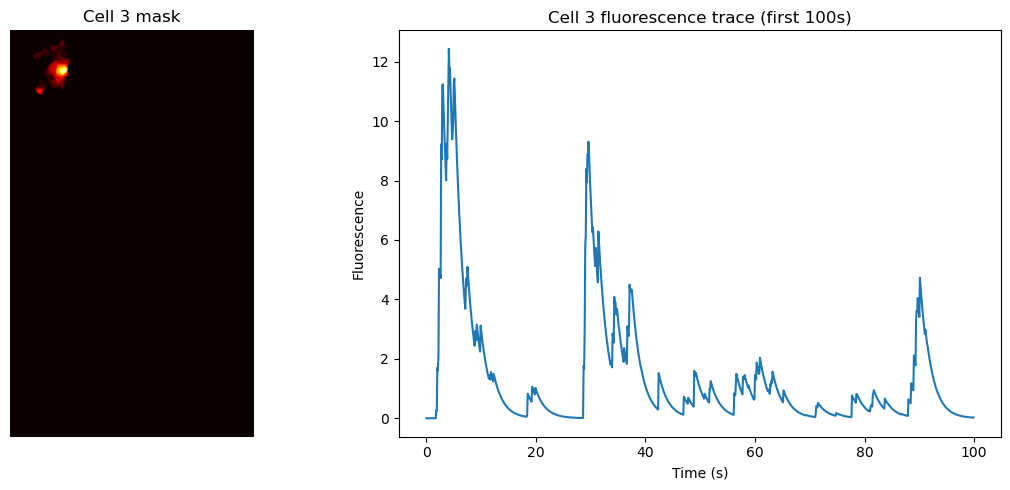

In [11]:
# Select a specific cell for combined spatial-temporal visualization
cell_idx = 3  # For example
mask = plane_seg['image_mask'].data[cell_idx][:]
trace = rrs.data[:1000, cell_idx]  # First 100 seconds (at 10 Hz)
time = np.arange(len(trace)) / sampling_rate

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='hot')
plt.title(f'Cell {cell_idx} mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.plot(time, trace)
plt.title(f'Cell {cell_idx} fluorescence trace (first 100s)')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence')
plt.tight_layout()
plt.show()

This visualization shows both the spatial footprint (mask) and temporal dynamics (fluorescence trace) for a single cell. This is useful for understanding the relationship between a cell's location in the field of view and its activity pattern.

## Summary and Next Steps

In this notebook, we've explored Dandiset 001174, which contains calcium imaging data from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques. We've examined:

- The organization of NWB files by subject and session
- The structure of an example NWB file and its key components
- Raw calcium imaging frames
- Segmented cell masks (ROIs) and their spatial distribution
- Fluorescence traces and event amplitudes
- Basic activity statistics like event rates

### Possible Next Steps

- Extract and analyze cellular activity across multiple sessions or subjects
- Examine synchrony and correlation between cells
- Investigate sequential activity patterns
- If behavioral data is available, relate neural activity to behavior
- Perform more advanced analyses like dimensionality reduction or spike inference

The tools and approaches demonstrated here provide a foundation for working with this dataset, and can be adapted for more sophisticated analyses depending on your research questions.